## Duplicate Image Filtration

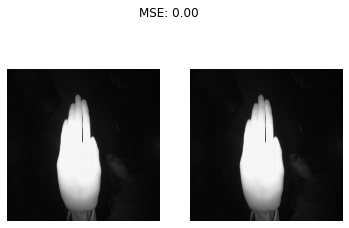

Duplicate files:
...ess-(GWAR)/Project/script_test_data/frame_00_01_0057.png and 
...ess-(GWAR)/Project/script_test_data/frame_00_01_0056.png
        
        


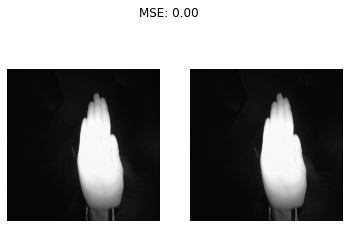

Duplicate files:
...ess-(GWAR)/Project/script_test_data/frame_00_01_0052.png and 
...ess-(GWAR)/Project/script_test_data/frame_00_01_0053.png
        
        

Deleted file: /Users/tirth/projects/college/DATA-270-Data Analyst-Process-(GWAR)/Project/script_test_data/frame_00_01_0053.png
Deleted file: /Users/tirth/projects/college/DATA-270-Data Analyst-Process-(GWAR)/Project/script_test_data/frame_00_01_0056.png
***
Deleted 2 images.
Found 2 images with one or more duplicate/similar images in 30.8414 seconds.

Could not delete file: /Users/tirth/projects/college/DATA-270-Data Analyst-Process-(GWAR)/Project/script_test_data/frame_00_01_0053.png
Could not delete file: /Users/tirth/projects/college/DATA-270-Data Analyst-Process-(GWAR)/Project/script_test_data/frame_00_01_0056.png
***
Deleted 0 images.


In [ ]:
import skimage.color
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import time
import collections

class Image_DeDuplicator:
    def __init__(self, directory, similarity="high", px_size=5000, sort_output=False, show_output=False, delete=False, silent_del=False):
  
        start_time = time.time()

        Image_DeDuplicator._process_directory(directory)

        result, lower_quality = Image_DeDuplicator._search_duplicate(
            directory, similarity, px_size, sort_output, show_output)
        if sort_output == True:
            result = collections.OrderedDict(sorted(result.items()))

        time_elapsed = np.round(time.time() - start_time, 4)
        self.lower_quality = lower_quality
        self.time_elapsed = time_elapsed

        if len(result) == 1:
            images = "image"
        else:
            images = "images"
        if len(result) != 0:
            if delete:
                if not silent_del:
                    usr = input(
                        "Are you sure you want to delete all lower resolution duplicate images? \nThis cannot be undone. (y/n)")
                    if str(usr) == "y":
                        Image_DeDuplicator._delete_imgs(set(lower_quality))
                    else:
                        print("Image deletion canceled.")
                else:
                    Image_DeDuplicator._delete_imgs(set(lower_quality))
        print("Found", len(result), images,
              "with one or more duplicate/similar images in", time_elapsed, "seconds.")

        if len(result) != 0:
            if delete:
                if not silent_del:
                    usr = input(
                        "Are you sure you want to delete all lower resolution duplicate images? \nThis cannot be undone. (y/n)")
                    if str(usr) == "y":
                        Image_DeDuplicator._delete_imgs(set(lower_quality))
                    else:
                        print("Image deletion canceled.")
                else:
                    Image_DeDuplicator._delete_imgs(set(lower_quality))

    def _search_duplicate(directory, similarity, px_size, sort_output, show_output):

        img_matrices_A, filenames_A = Image_DeDuplicator._create_imgs_matrix(directory, px_size)
        result = {}
        lower_quality = []

        ref = Image_DeDuplicator._map_similarity(similarity)

        # find duplicates/similar images within one folder
        for count_A, imageMatrix_A in enumerate(img_matrices_A):
            for count_B, imageMatrix_B in enumerate(img_matrices_A):
                if count_B != 0 and count_B > count_A and count_A != len(img_matrices_A):
                    rotations = 0
                    while rotations <= 3:
                        if rotations != 0:
                            imageMatrix_B = Image_DeDuplicator._rotate_img(
                                imageMatrix_B)

                        err = Image_DeDuplicator._mse(imageMatrix_A, imageMatrix_B)
                        if err < ref:
                            if show_output:
                                Image_DeDuplicator._show_img_figs(
                                    imageMatrix_A, imageMatrix_B, err)
                                Image_DeDuplicator._show_file_info(str("..." + directory[-35:]) + "/" + filenames_A[count_A],
                                                              str("..." + directory[-35:]) + "/" + filenames_A[count_B])
                            if filenames_A[count_A] in result.keys():
                                result[filenames_A[count_A]]["duplicates"] = result[filenames_A[count_A]
                                                                                    ]["duplicates"] + [directory + "/" + filenames_A[count_B]]
                            else:
                                result[filenames_A[count_A]] = {"location": directory + "/" + filenames_A[count_A],
                                                                "duplicates": [directory + "/" + filenames_A[count_B]]
                                                                }
                            high, low = Image_DeDuplicator._check_img_quality(
                                directory, directory, filenames_A[count_A], filenames_A[count_B])
                            lower_quality.append(low)
                            break
                        else:
                            rotations += 1
        if sort_output == True:
            result = collections.OrderedDict(sorted(result.items()))
        return result, lower_quality

    def _process_directory(directory):
        # check if directories are valid
        directory += os.sep
        if not os.path.isdir(directory):
            raise FileNotFoundError(
                f"Directory: " + directory + " does not exist")
        return directory

    def _create_imgs_matrix(directory, px_size):
        directory = Image_DeDuplicator._process_directory(directory)
        img_filenames = []
        # create list of all files in directory
        folder_files = [filename for filename in os.listdir(directory)]

        # create images matrix
        imgs_matrix = []
        for filename in folder_files:
            path = os.path.join(directory, filename)
            # check if the file is not a folder
            if not os.path.isdir(path):
                try:
                    img = cv2.imread(path)
                    if type(img) == np.ndarray:
                        img = img[..., 0:3]
                        img = cv2.resize(img, dsize=(
                            px_size, px_size), interpolation=cv2.INTER_CUBIC, )

                        if len(img.shape) == 2:
                            img = skimage.color.gray2rgb(img)
                        imgs_matrix.append(img)
                        img_filenames.append(filename)
                except:
                    pass
        return imgs_matrix, img_filenames

    def _map_similarity(similarity):
        if similarity == "low":
            ref = 1000
        # search for exact duplicate images, extremely sensitive, MSE < 0.1
        elif similarity == "high":
            ref = 0.1
        # normal, search for duplicates, recommended, MSE < 200
        else:
            ref = 200
        return ref

    # Function that calculates the mean squared error (mse) between two image matrices
    def _mse(imageA, imageB):
        err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
        err /= float(imageA.shape[0] * imageA.shape[1])
        return err

    # Function that plots two compared image files and their mse
    def _show_img_figs(imageA, imageB, err):
        fig = plt.figure()
        plt.suptitle("MSE: %.2f" % (err))
        # plot first image
        ax = fig.add_subplot(1, 2, 1)
        plt.imshow(imageA, cmap=plt.cm.gray)
        plt.axis("off")
        # plot second image
        ax = fig.add_subplot(1, 2, 2)
        plt.imshow(imageB, cmap=plt.cm.gray)
        plt.axis("off")
        # show the images
        plt.show()

    # Function for printing filename info of plotted image files
    def _show_file_info(imageA, imageB):
        print("""Duplicate files:\n{} and \n{}
        
        """.format(imageA, imageB))

    # Function for rotating an image matrix by a 90 degree angle
    def _rotate_img(image):
        image = np.rot90(image, k=1, axes=(0, 1))
        return image

    # Function for checking the quality of compared images, appends the lower quality image to the list
    def _check_img_quality(directoryA, directoryB, imageA, imageB):
        dirA = Image_DeDuplicator._process_directory(directoryA)
        dirB = Image_DeDuplicator._process_directory(directoryB)
        size_imgA = os.stat(dirA + imageA).st_size
        size_imgB = os.stat(dirB + imageB).st_size
        if size_imgA >= size_imgB:
            return directoryA + "/" + imageA, directoryB + "/" + imageB
        else:
            return directoryB + "/" + imageB, directoryA + "/" + imageA

    # Function for deleting the lower quality images that were found after the search
    def _delete_imgs(image_list):
        deleted = 0
        for file in image_list:
            print("\nDeletion in progress...", end="\r")
            try:
                os.remove(file)
                print("Deleted file:", file, end="\r")
                deleted += 1
            except:
                pass
        print("\n***\nDeleted", deleted, "images.")

Image_DeDuplicator('/Users/tirth/projects/college/DATA-270-Data Analyst-Process-(GWAR)/Project/script_test_data', show_output=True, delete=True, silent_del=True)

## Blur Image Filtration

In [ ]:
import skimage.color
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import time
import collections

class Image_Blur_Filterer:
    def __init__(self, directory, px_size=5000, show_output=False, delete=False, silent_del=False, threshold=0.65):
  
        start_time = time.time()

        Image_Blur_Filterer._process_directory(directory)

        result, blurry_images = Image_Blur_Filterer._search_blurry( directory, px_size, threshold, show_output)
        self.blurry_images = blurry_images
        time_elapsed = np.round(time.time() - start_time, 4)

        self.time_elapsed = time_elapsed

        if len(result) == 1:
            images = "image"
        else:
            images = "images"
        print("Found", len(result), images,
              "with one or more blurry images in", time_elapsed, "seconds.")

        if len(result) != 0:
            if delete:
                if not silent_del:
                    usr = input(
                        "Are you sure you want to delete all blurry images? \nThis cannot be undone. (y/n)")
                    if str(usr) == "y":
                        Image_Blur_Filterer._delete_imgs(set(blurry_images))
                    else:
                        print("Image deletion canceled.")
                else:
                    Image_Blur_Filterer._delete_imgs(set(blurry_images))

    def _search_blurry(directory, px_size, threshold, show_output):

        img_matrices, filenames = Image_Blur_Filterer._create_imgs_matrix(directory, px_size)
        blurry_images = []
        result = {}

        # find duplicates/similar images within one folder
        for count_A, imageMatrix_A in enumerate(img_matrices):
            gray = cv2.cvtColor(imageMatrix_A, cv2.COLOR_BGR2GRAY)
            fm = cv2.Laplacian(gray, cv2.CV_64F).var()
            # if the focus measure is less than the supplied threshold,
            # then the image should be considered "blurry"
            if fm < threshold:
                result[filenames[count_A]] = filenames[count_A]
                blurry_images.append(directory + "/" + filenames[count_A])
                # show the image
                Image_Blur_Filterer._show_img_figs(gray, filenames[count_A], fm)
        if show_output:
            print(blurry_images)
        return result, blurry_images

    def _process_directory(directory):
        # check if directories are valid
        directory += os.sep
        if not os.path.isdir(directory):
            raise FileNotFoundError(
                f"Directory: " + directory + " does not exist")
        return directory

    def _create_imgs_matrix(directory, px_size):
        directory = Image_Blur_Filterer._process_directory(directory)
        img_filenames = []
        # create list of all files in directory
        folder_files = [filename for filename in os.listdir(directory)]

        # create images matrix
        imgs_matrix = []
        for filename in folder_files:
            path = os.path.join(directory, filename)
            # check if the file is not a folder
            if not os.path.isdir(path):
                try:
                    img = cv2.imread(path)
                    if type(img) == np.ndarray:
                        img = img[..., 0:3]
                        img = cv2.resize(img, dsize=(
                            px_size, px_size), interpolation=cv2.INTER_CUBIC, )

                        if len(img.shape) == 2:
                            img = skimage.color.gray2rgb(img)
                        imgs_matrix.append(img)
                        img_filenames.append(filename)
                except:
                    pass
        return imgs_matrix, img_filenames

    
    def _show_img_figs(image, image_name, fm):
        fig = plt.figure()
        plt.suptitle(f"Name: {image_name}")
        plt.title(f"Threshold: {round(fm, 2)}")
        # plot first image
        ax = fig.add_subplot(1, 2, 1)
        plt.imshow(image, cmap=plt.cm.gray)
        plt.axis("off")
        # show the images
        plt.show()

    # Function for deleting the lower quality images that were found after the search
    def _delete_imgs(image_list):
        deleted = 0
        for file in image_list:
            print("\nDeletion in progress...", end="\r")
            try:
                os.remove(file)
                print("Deleted file:", file, end="\r")
                deleted += 1
            except:
                print("Could not delete file:", file, end="\r")
        print("\n***\nDeleted", deleted, "images.")

Image_Blur_Filterer('/Users/tirth/projects/college/DATA-270-Data Analyst-Process-(GWAR)/Project/script_test_data', show_output=True, silent_del=True, delete=True)

[]
Found 0 images with one or more blurry images in 0.5162 seconds.


## SVD on dataset

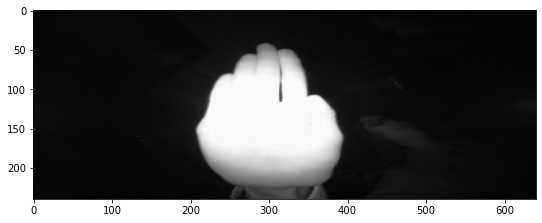

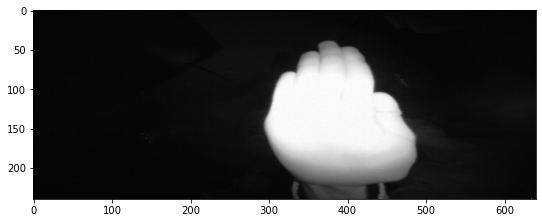

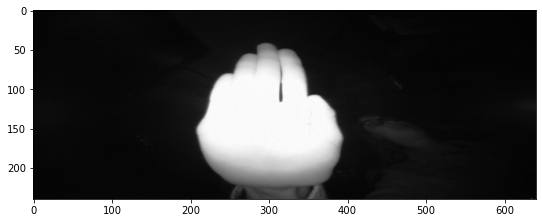

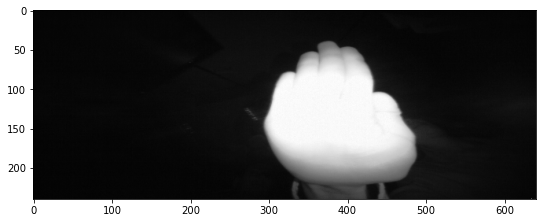

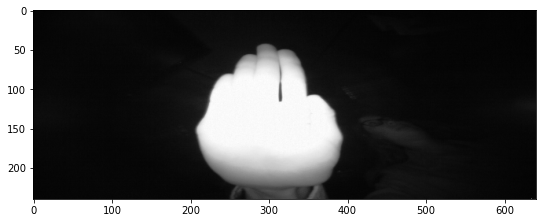

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib import cm
from skimage import io
import time

from PIL import Image
from scipy.linalg import svd as SVD


class SVD_Project:
    def __init__(self, directory, componentCount):
      img_names = SVD_Project._create_imgs_matrix(directory)
      SVD_Project._perform_svd(directory, img_names, componentCount)

    def _create_imgs_matrix(directory):
        directory = SVD_Project._process_directory(directory)
        img_filenames = []
        # create list of all files in directory
        folder_files = [filename for filename in os.listdir(directory)]

        for filename in folder_files:
            path = os.path.join(directory, filename)
            # check if the file is not a folder
            if not os.path.isdir(path):
                try:
                    img = io.imread(f"{path}")
                    if type(img) == np.ndarray:
                        img_filenames.append(filename)
                except Exception as e:
                  pass
        return img_filenames

    def _perform_svd(directory, image_names, componentCount):
        for image_number, image_name in enumerate(image_names):
            path = os.path.join(directory, image_name)
            img = Image.open(f"{path}")
            imggray = img.convert('LA')
            imgmat = np.array(list(imggray.getdata(band=0)), float)
            imgmat.shape = (imggray.size[1], imggray.size[0])
            imgmat = np.matrix(imgmat)
            plt.figure(figsize=(9,6))

            U, S, V = SVD(imgmat)

            def get_compressed_image(orig_U, orig_S, orig_V, componet_count):
                SK = np.zeros((componet_count, componet_count))
                for i in range(componet_count):
                    SK[i, i] = orig_S[i]
                UK = orig_U[:, 0:componet_count]
                VK = orig_V[0:componet_count, :]
                ImgK = UK @ SK @ VK
                return (UK, SK, VK, ImgK)

            (U200, S200, V200, Img200) = get_compressed_image(
                U, S, V, componet_count=componentCount)
            plt.imshow(Img200, 'gray')
            if not os.path.exists(f"{directory}/reduced_image"):
              os.makedirs(f"{directory}/reduced_image")
            mplimg.imsave(f"{directory}/reduced_image/{image_name}", Img200, cmap = cm.gray)
            # plt.close()
            img.close()
            

    def _process_directory(directory):
        # check if directories are valid
        directory += os.sep
        if not os.path.isdir(directory):
            raise FileNotFoundError(
                f"Directory: " + directory + " does not exist")
        return directory

SVD_Project('/Users/tirth/projects/college/DATA-270-Data Analyst-Process-(GWAR)/Project/script_test_data', 150)

## Data Augmentation Image

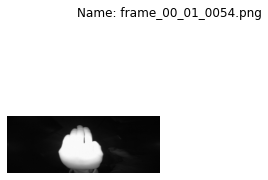

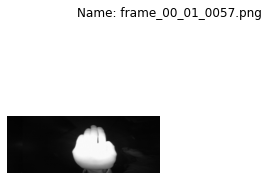

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Created file: frame_00_01_0054.png
Created file: frame_00_01_0057.png
***
Created 2 images.


In [ ]:
import skimage.color
import matplotlib.pyplot as plt
from skimage import transform as Transform
import numpy as np
from skimage import io
import random
import cv2
import os
import time
import collections


class Data_Augmentor:
    def __init__(self, directory, px_size=5000, show_output=False):

        start_time = time.time()

        Data_Augmentor._process_directory(directory)

        Data_Augmentor._create_augments(directory, px_size, show_output)

        time_elapsed = np.round(time.time() - start_time, 4)
        self.time_elapsed = time_elapsed

    def _create_augments(directory, px_size, show_output):

        should_process = [True, False]
        img_matrices, filenames = Data_Augmentor._create_imgs_matrix(directory)

        processed_images = []
        image_names = []

        # find duplicates/similar images within one folder
        for count_A, imageMatrix in enumerate(img_matrices):
            if random.choice(should_process) is True:
                imageMatrix = Data_Augmentor._transform_img(imageMatrix)
                processed_images.append(imageMatrix)
                image_names.append(filenames[count_A])
                if show_output:
                    Data_Augmentor._show_img_figs(
                        imageMatrix, filenames[count_A])

        Data_Augmentor._create_imgs(directory, processed_images, image_names)

    def _process_directory(directory):
        # check if directories are valid
        directory += os.sep
        if not os.path.isdir(directory):
            raise FileNotFoundError(
                f"Directory: " + directory + " does not exist")
        return directory

    def _create_imgs_matrix(directory):
        directory = Data_Augmentor._process_directory(directory)
        img_filenames = []
        # create list of all files in directory
        folder_files = [filename for filename in os.listdir(directory)]

        # create images matrix
        imgs_matrix = []
        for filename in folder_files:
            path = os.path.join(directory, filename)
            # check if the file is not a folder
            if not os.path.isdir(path):
                try:
                    img = io.imread(f"{path}")
                    if type(img) == np.ndarray:
                        if len(img.shape) == 2:
                            img = skimage.color.gray2rgb(img)
                        imgs_matrix.append(img)
                        img_filenames.append(filename)
                except:
                    pass
        return imgs_matrix, img_filenames

    # Function that plots two compared image files and their mse

    def _show_img_figs(image, image_name):
        fig = plt.figure()
        plt.suptitle(f"Name: {image_name}")
        # plot first image
        ax = fig.add_subplot(1, 2, 1)
        plt.imshow(image, cmap=plt.cm.gray)
        plt.axis("off")
        # show the images
        plt.show()

    # Function for transforming an image matrix 
    def _transform_img(image):
        transform = Transform.AffineTransform(
            translation=(-random.randrange(1, 100), 0))
        warp_image = Transform.warp(image, transform, mode="wrap")
        return warp_image

    # Function for deleting the lower quality images that were found after the search
    def _create_imgs(directory, image_list, image_name_list):
        created = 0
        if not os.path.exists(f"{directory}/augmented"):
            os.makedirs(f"{directory}/augmented")
        for image_number, image in enumerate(image_list):
            print("\nCreation in progress...", end="\r")
            try:
                io.imsave(
                    f"{directory}/augmented/augmented-{image_name_list[image_number]}", image)
                print("Created file:", image_name_list[image_number], end="\r")
                created += 1
            except:
                print("Could not create file:",
                      image_name_list[image_number], end="\r")
        print("\n***\nCreated", created, "images.")


Data_Augmentor(
    '/Users/tirth/projects/college/DATA-270-Data Analyst-Process-(GWAR)/Project/script_test_data/reduced_image', show_output=True)
